In [1]:
import dataset
import h5py
import cv2
import numpy as np
from utils import *
from rpn import *
import torch
from torchvision import transforms, ops
from torchsummary import summary
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

## Load dataset ##
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
FRCNNdataset = dataset.BuildDataset(paths)
# build the dataloader with 80% train and 20% validation
full_size = len(FRCNNdataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
train_dataset, test_dataset = torch.utils.data.random_split(FRCNNdataset, [train_size, test_size])
# push the randomized training data into the dataloader
batch_size = 1
train_build_loader = dataset.BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = dataset.BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

## Load pre-trained RPN model ##
rpn_net = RPNHead().cuda()
rpn_net.load_state_dict(torch.load("result/best-kval-epoch=64-val_loss=1.56.ckpt")["state_dict"])
rpn_net.eval()

RPNHead(
  (backbone): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Re

1. Visual correctness check

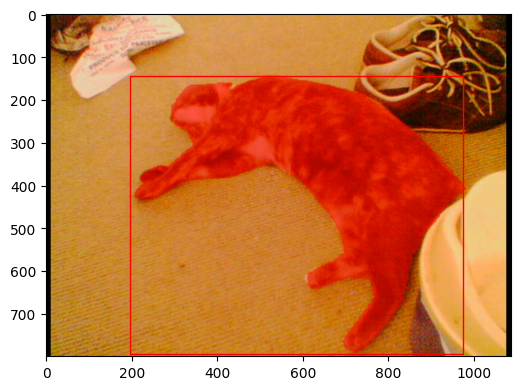

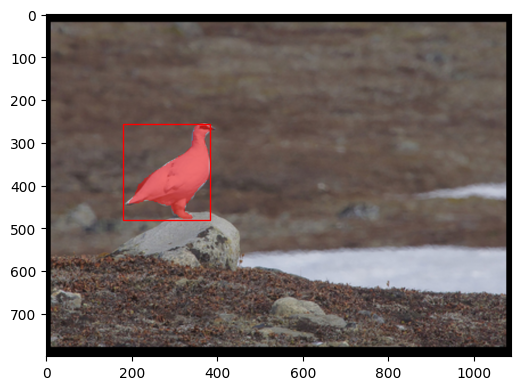

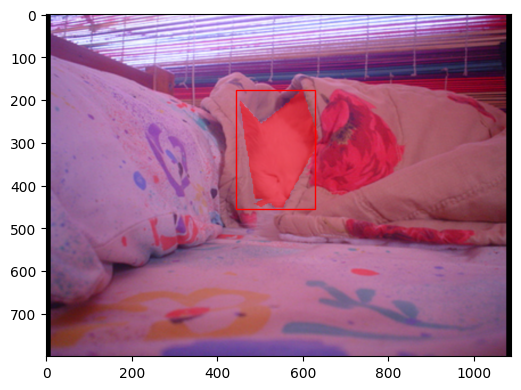

In [2]:
for i, batch in enumerate(train_loader,0):
    images = batch['images']
    indexes = batch['index']
    boxes = batch['bbox']
    label = batch['labels']
    mask = batch['masks']
    FRCNNdataset.visualSampleImage(FRCNNdataset, indexes)
    if i == 2:
        break

2. Histograms of scales and aspect ratios

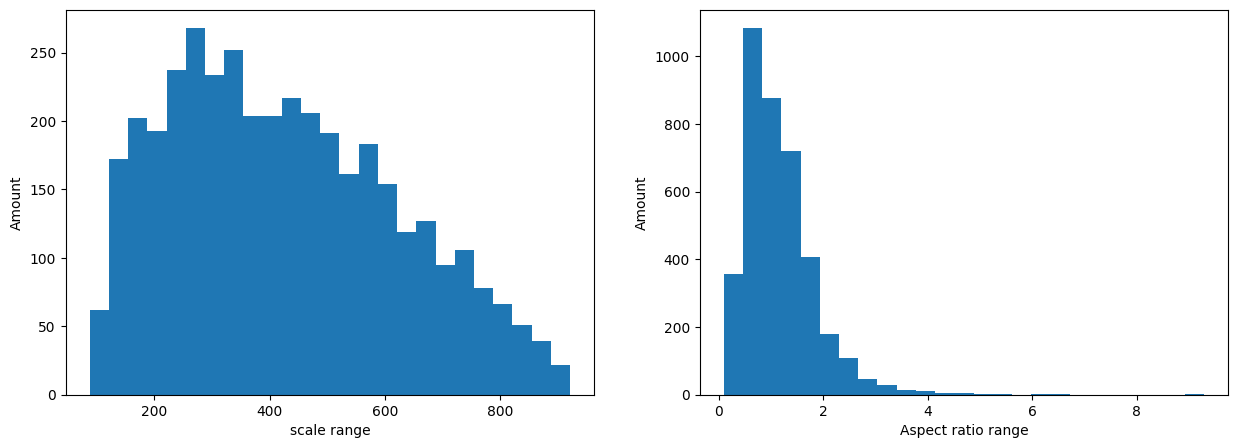

In [3]:
FRCNNdataset.histogramScaleRatio()

3. Positive anchors and corresponding ground truth boxes

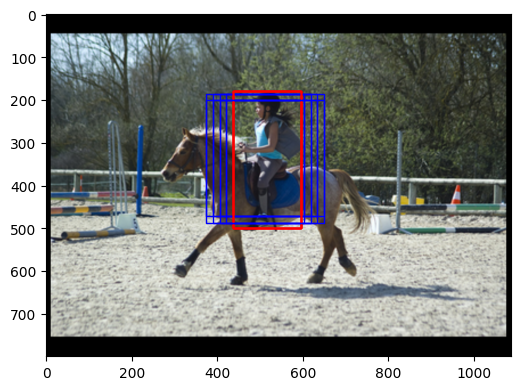

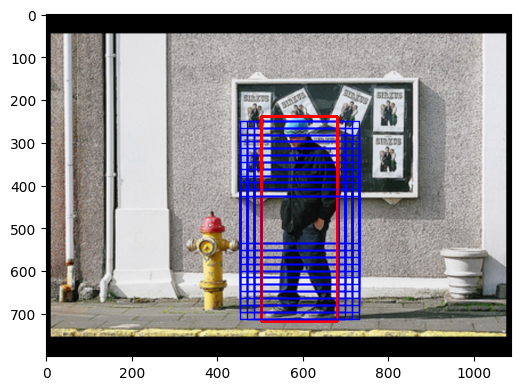

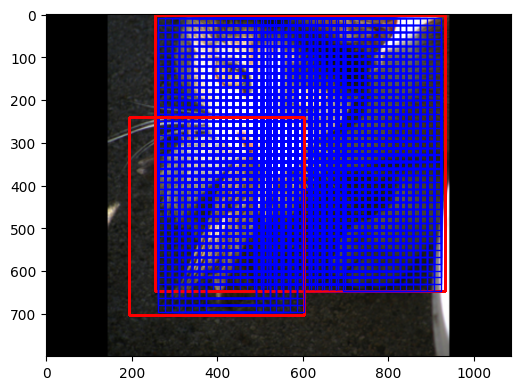

In [4]:
for i, batch in enumerate(train_loader,0):
    images = batch['images']
    indexes = batch['index']
    boxes = batch['bbox']
    label = batch['labels']
    mask = batch['masks']
    FRCNNdataset.visualGTCreation(images.squeeze(0), boxes[0], indexes[0], rpn_net)
    if i == 2:
        break

4. Training and Validation curves

Text(0.5, 1.0, 'Smoothed validation loss')

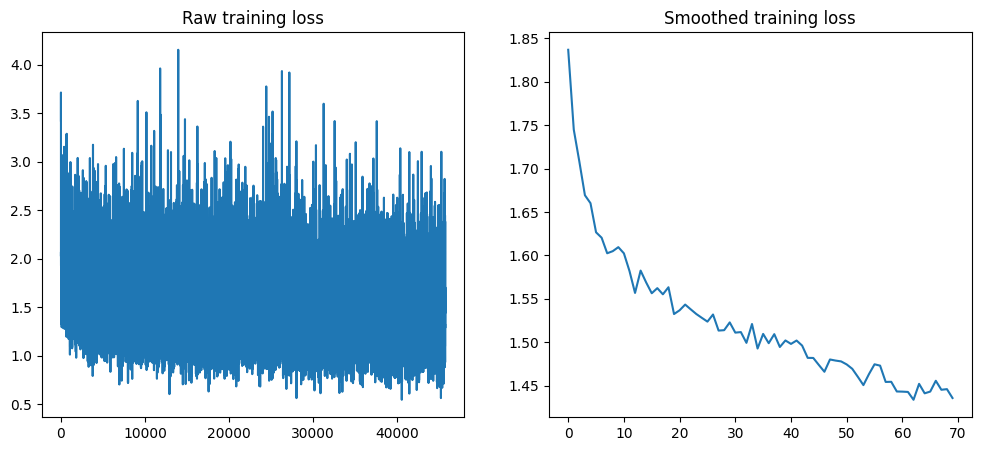

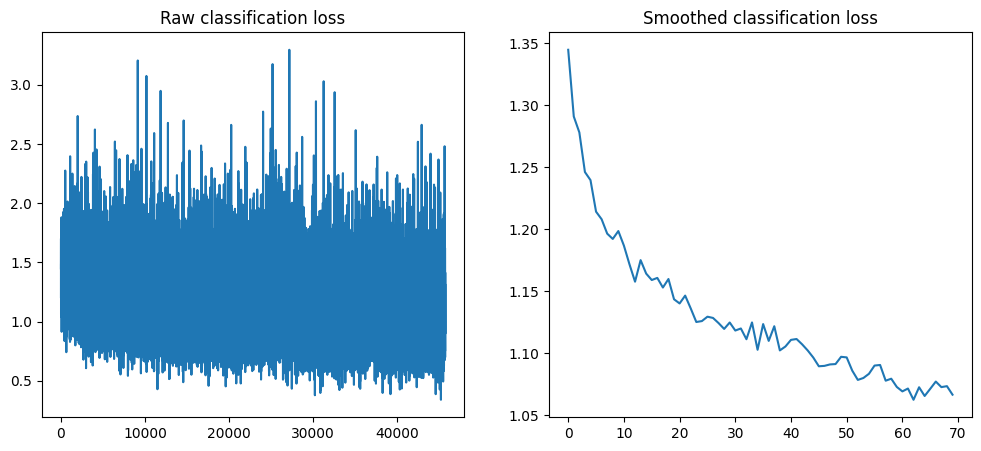

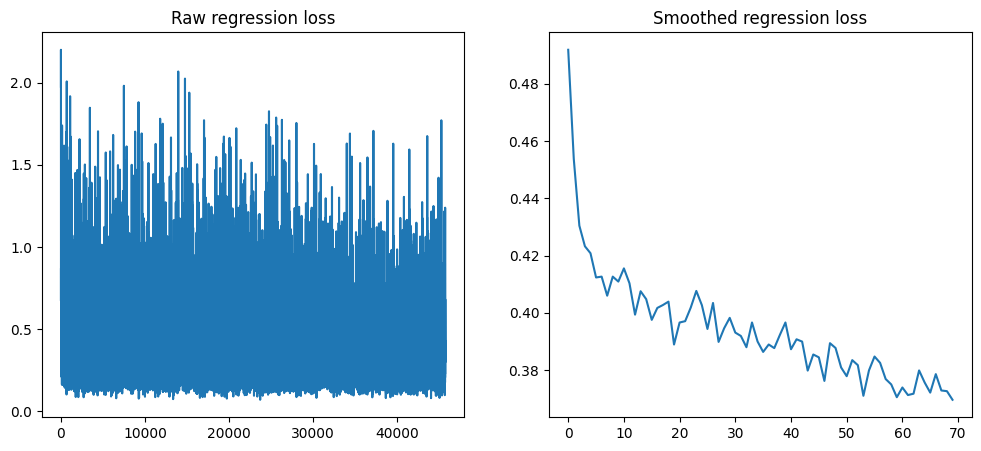

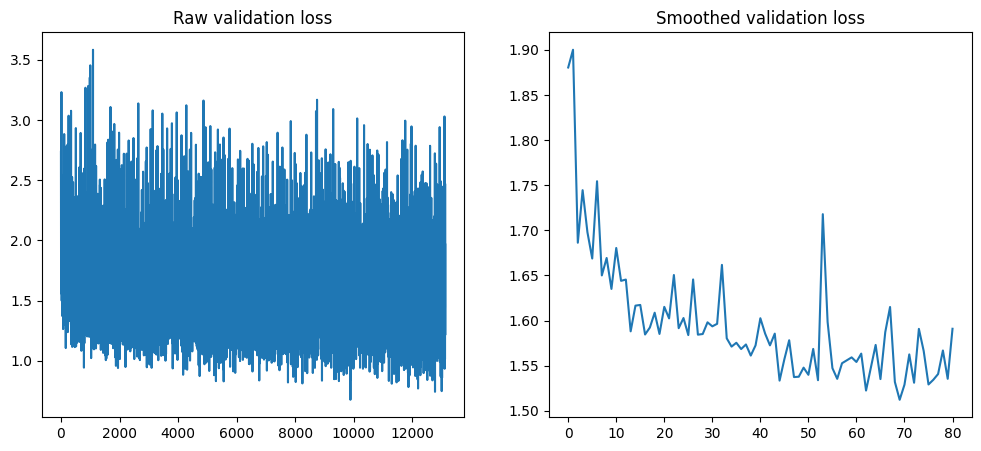

In [5]:
train_loss = np.load('result/total_loss.npy',allow_pickle=True)
cls_loss = np.load('result/cls_loss.npy',allow_pickle=True)
reg_loss = np.load('result/reg_loss.npy',allow_pickle=True)
val_loss = np.load('result/val_loss.npy',allow_pickle=True)
# Training loss
fig, ax =plt.subplots(1,2,figsize=(12,5))
ax[0].plot(train_loss)
ax[0].set_title('Raw training loss')
avg_total_loss = []
step = 653
for i in range(0, len(train_loss), step):
    avg_total_loss.append(np.mean(train_loss[i:i+step]))
ax[1].plot(avg_total_loss)
ax[1].set_title('Smoothed training loss')
# Classification loss
fig, ax =plt.subplots(1,2,figsize=(12,5))
ax[0].plot(cls_loss)
ax[0].set_title('Raw classification loss')
avg_total_loss = []
step = 653
for i in range(0, len(cls_loss), step):
    avg_total_loss.append(np.mean(cls_loss[i:i+step]))
ax[1].plot(avg_total_loss)
ax[1].set_title('Smoothed classification loss')
# Regression loss
fig, ax =plt.subplots(1,2,figsize=(12,5))
ax[0].plot(reg_loss)
ax[0].set_title('Raw regression loss')
avg_total_loss = []
step = 653
for i in range(0, len(reg_loss), step):
    avg_total_loss.append(np.mean(reg_loss[i:i+step]))
ax[1].plot(avg_total_loss)
ax[1].set_title('Smoothed regression loss')
# Validation loss
fig, ax =plt.subplots(1,2,figsize=(12,5))
ax[0].plot(val_loss)
ax[0].set_title('Raw validation loss')
avg_total_loss = []
step = 164
for i in range(0, len(val_loss), step):
    avg_total_loss.append(np.mean(val_loss[i:i+step]))
ax[1].plot(avg_total_loss)
ax[1].set_title('Smoothed validation loss')

5. Plots of the top 20 proposals & point wise accuracy

point-wise accuracy is 0.7015239


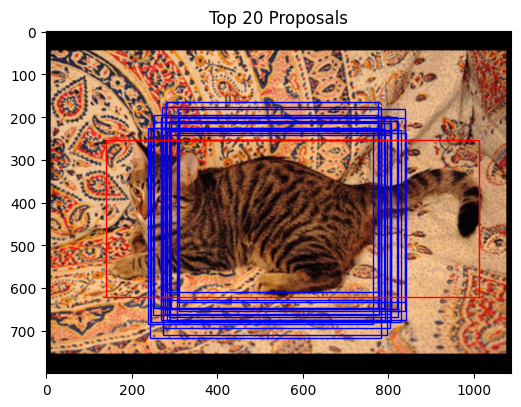

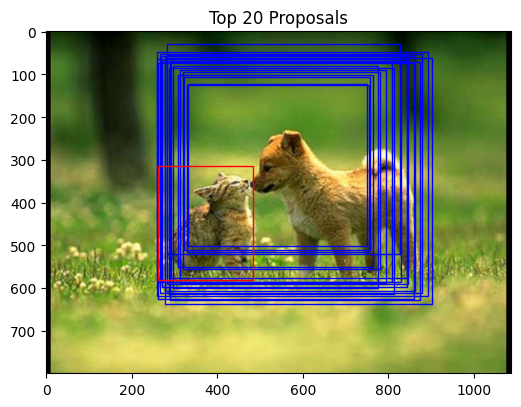

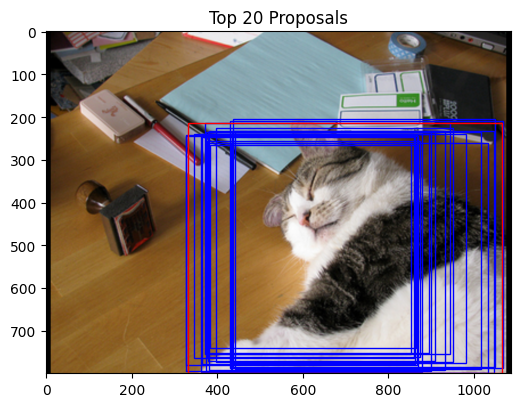

In [6]:
for i, batch in enumerate(test_loader,0):
    images = batch['images']
    indexes = batch['index']
    boxes = batch['bbox']
    label = batch['labels']
    mask = batch['masks']
    rpn_net.visualTop20(rpn_net, images.squeeze(0), boxes[0])
    if i == 2:
        break

total_count = 0
total_corr = 0
for i, batch in enumerate(test_loader,0):
    images = batch['images']
    indexes = batch['index']
    boxes = batch['bbox']
    # GT classification
    gt, _ = rpn_net.create_batch_truth(boxes, indexes, images.shape[-2:])
    gt_cls = gt.squeeze()
    pos_gt_cls = gt_cls == 1
    bkd_gt_cls = gt_cls == -1
    # Prediction classification
    logits, _ = rpn_net.forward(images.cuda())
    pred_cls = logits.squeeze().cpu().detach()
    pos_pred_cls = pred_cls > 0.5
    bkd_pred_cls = pred_cls <= 0.5
    # Compute the intesection between gt-pos and pred-pos
    total_corr += torch.logical_and(pos_gt_cls, pos_pred_cls).sum() + torch.logical_and(bkd_gt_cls, bkd_pred_cls).sum()
    total_count += (gt_cls != 0).sum()
acc = total_corr / total_count
print("point-wise accuracy is "+ str(acc.detach().numpy()))

6. Visualization of the proposed boxes before and after the NMS

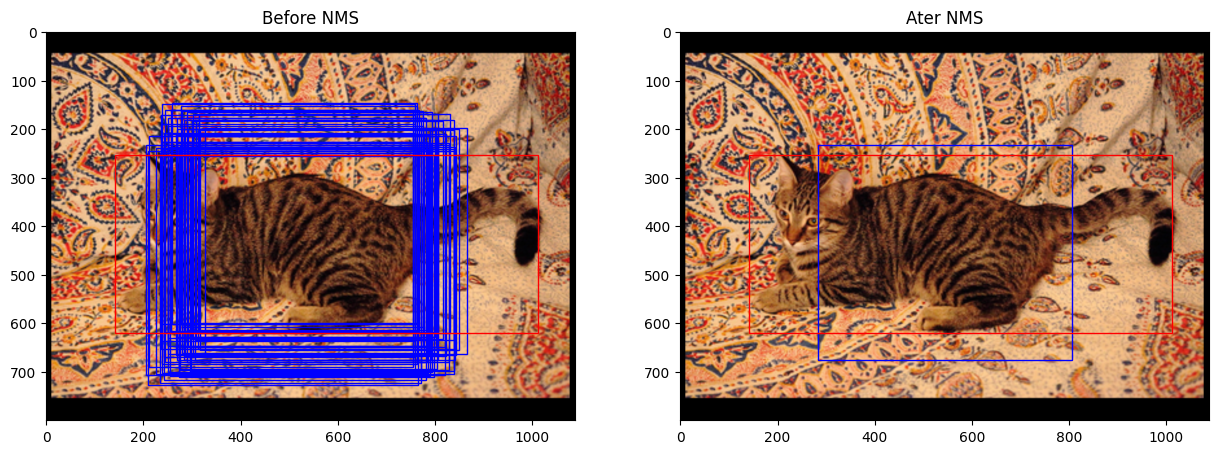

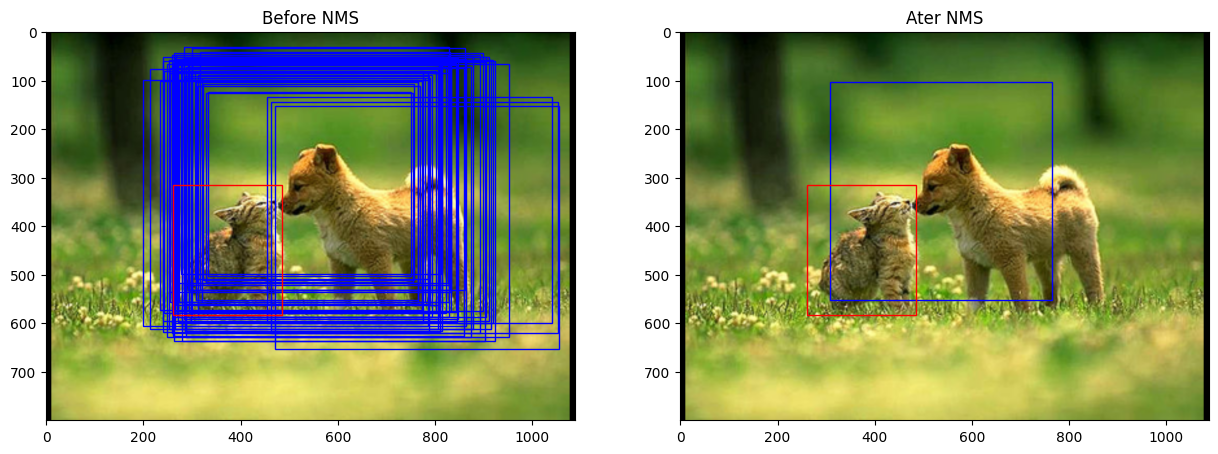

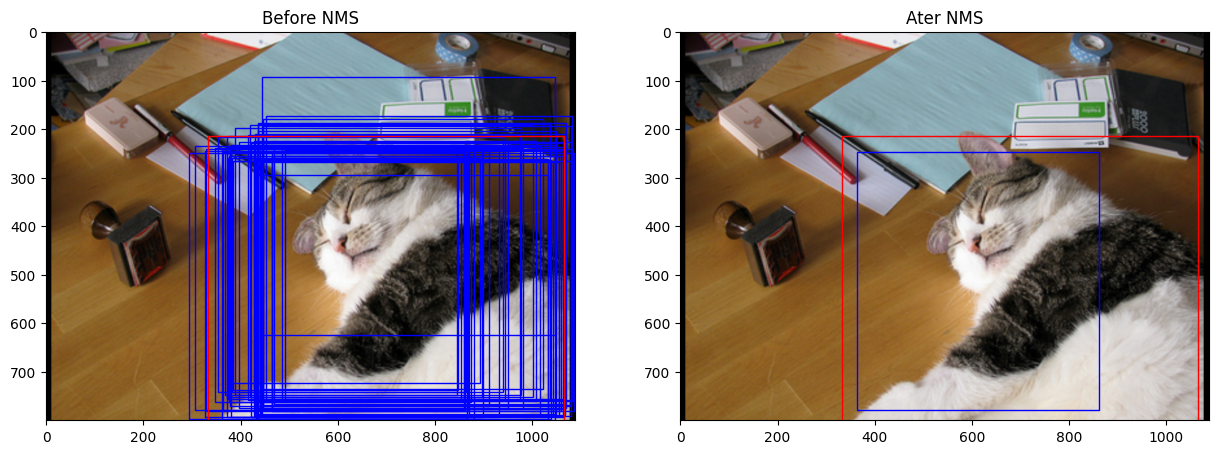

In [7]:
# images, label, mask, boxes, indexes = FRCNNdataset[2264] # 207, 505, 1242, 730, 732, 734, 738, || 2013, 489, 1242, 2264
# rpn_net.visualNMS(rpn_net, images, boxes)
for i, batch in enumerate(test_loader,0):
    images = batch['images']
    indexes = batch['index']
    boxes = batch['bbox']
    label = batch['labels']
    mask = batch['masks']
    rpn_net.visualNMS(rpn_net, images.squeeze(0), boxes[0])
    if i == 2:
        break